## Conditional Res-Unet

Двигаем цифры на картинке с помощью нейронки, подавая дополнительное условие (интересующее направление сдвига)

torch_version: 1.10.0,
torchvision_version: 0.11.1
device: cuda:0 

train data: torch.Size([60000, 28, 28]) torch.Size([60000])
test data: torch.Size([10000, 28, 28]) torch.Size([10000])
train data's type: torch.ByteTensor torch.LongTensor
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)


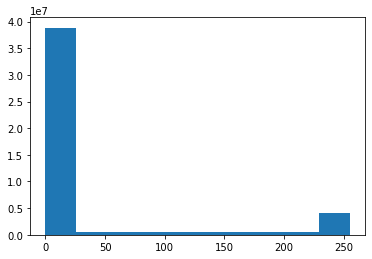

In [95]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import models
from torchsummary import summary
import albumentations as A
from albumentations.pytorch import ToTensorV2, transforms
import numpy as np
import seaborn as sns
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

def see_plot(pict, color='gray', size=(4,4)):
    plt.figure(figsize=size)
    plt.imshow(pict, cmap=color)
    plt.xticks([16,32,48,64,80,96,112,128])
    plt.yticks([16,32,48,64])
    plt.grid()
    #plt.axis('off')
    plt.show()
    
def plot_samples_on_epoch(samples, nrow=8, chanels=3, size=(8,8)):
    grid_img = torchvision.utils.make_grid(samples, nrow=nrow)
    if chanels==1:
        see_plot(grid_img.permute(1, 2, 0)*255, size=size)
    else:
        see_plot(grid_img.permute(1, 2, 0), size=size)
#----------------------------------------------------------------------------------------------------
        
# data       
train_set = torchvision.datasets.MNIST(root=".", train=True, download=True)
test_set = torchvision.datasets.MNIST(root=".", train=False, download=True)

# info
print('torch_version: {},\ntorchvision_version: {}'.format(torch.__version__,torchvision.__version__))
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('device:', device, '\n')

print('train data:', train_set.data.shape, train_set.targets.shape)
print('test data:', test_set.data.shape, test_set.targets.shape)
print('train data\'s type:', train_set.data[0].type(), train_set.targets[0].type()) # torch.uint8
print(train_set.data.max(),train_set.data.min()) # torch.uint8
plt.hist(train_set.data.view(60000*28*28,1).numpy());

In [2]:
class MNIST_Dataset(Dataset):
    def __init__(self,
                 dataset,
                 augs=None):
        super().__init__()
        d = 10
        self.dataset = dataset
        self.augs = augs
        self.dir = {0:(0,0,0),
                    1:(0,0,d),   #'W'
                    2:(0,-d,d),  #'W+D'
                    3:(0,-d,0),  #'D'
                    4:(0,-d,-d), #'S+D'
                    5:(0,0,-d),  #'S'
                    6:(0,d,-d),  #'S+A'
                    7:(0,d,0),   #'A'
                    8:(0,d,d),}  #'W+A'

        
    def __len__(self):
        return self.dataset.shape[0]
    
    def __getitem__(self, idx):
        _dir = np.random.randint(8)+1
        img = self.dataset[idx].numpy()
        if self.augs is not None:
            img = self.augs(image=img)['image']
        target = torch.roll(img, self.dir[_dir], (0,2,1))
        

        _,w,h = img.size()
        img = img.expand_as(torch.zeros(3,w,h))
        target = target.expand_as(torch.zeros(3,w,h))
        _dir = F.one_hot(torch.tensor(_dir-1), num_classes=8)
        
        return img, target, _dir.float()

In [3]:
train_aug = A.Compose([A.augmentations.geometric.resize.Resize(64,64),
                       A.Normalize(mean=(0.5,), std=(0.5,)),
                       A.Flip(p=0.5),
                       A.RandomRotate90(p=0.5),
                       ToTensorV2(transpose_mask=False),
                      ])

test_aug = A.Compose([A.augmentations.geometric.resize.Resize(64,64),
                      A.Normalize(mean=(0.5,), std=(0.5,)),
                      ToTensorV2(transpose_mask=False),
                      ])

my_batch = 32
train_data = MNIST_Dataset(train_set.data, augs=train_aug)
train_dataloader = DataLoader(train_data, batch_size=my_batch, shuffle=True)
test_data = MNIST_Dataset(test_set.data, augs=test_aug)
test_dataloader = DataLoader(test_data, batch_size=my_batch, shuffle=False)

In [21]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )

class ResNetUNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = models.resnet18(pretrained=True)
        
        self.base_layers = list(self.base_model.children())                
        
        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)        
        self.layer1_1x1 = convrelu(64, 64, 1, 0)       
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)        
        self.layer2_1x1 = convrelu(128, 128, 1, 0)  
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)        
        self.layer3_1x1 = convrelu(256, 256, 1, 0)  
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)  
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)
        
        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)
        self.dropout = nn.Dropout(0.5)
        self.conv_last = nn.Conv2d(64, n_class, 1)
        self.act_last = nn.Tanh()
        self.support_conv1 = nn.Conv2d(8, 512, 1) # (bath,8) --> (batch,512)
        
    def forward(self, inp):

        x_original = self.conv_original_size0(inp[0])
        x_original = self.conv_original_size1(x_original)
        
        layer0 = self.layer0(inp[0])            
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)        
        layer4 = self.layer4(layer3)
        
        cond = self.support_conv1(torch.unsqueeze(torch.unsqueeze(inp[1], 2), 2)) # ([8, 8]) --> Size([8, 512, 1, 1])
        layer4 = self.layer4_1x1(layer4 + cond) 
        
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)
 
        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)
        
        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)        
        
        x = self.dropout(x)
        out = self.conv_last(x)
        out = self.act_last(out)
        
        return out

In [22]:
trainloss_ts = []
trainiou_ts = []
valloss_ts = []
valiou_ts = []

def train_model(model, train_iterator, val_iterator, loss_func, optimizer, sheduler, params):
    
    best_model_wts = model.state_dict()
    best_loss = 1000
    
    for i in range(params['EPOCHS']):
        #===========TRAIN=============================
        time.sleep(0.2)
        model.train(True)
        train_loss = 0.0
        for x in enumerate(tqdm(train_iterator)):
            img = x[1][0].to(params['DEVICE'])
            target = x[1][1].to(params['DEVICE'])
            _dir = x[1][2].to(params['DEVICE'])
            optimizer.zero_grad()
            prediction = model((img,_dir))
            loss = loss_func(prediction, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() 
        current_lr = optimizer.param_groups[0]['lr']
        sheduler.step()
        train_loss = round(train_loss / len(train_iterator),4)
        trainloss_ts.append(train_loss)

        #===========VAL==============================
        time.sleep(0.2)
        model.train(False)
        val_loss = 0.0
        for x in enumerate(val_iterator):
            img = x[1][0].to(params['DEVICE'])
            target = x[1][1].to(params['DEVICE'])
            _dir = x[1][2].to(params['DEVICE'])
            with torch.no_grad():
                prediction = model((img,_dir))  
            loss = loss_func(prediction, target)   
            val_loss += loss.item()
        val_loss = round(val_loss / len(val_iterator),4)
        valloss_ts.append(val_loss)

        if val_loss<best_loss:
            best_loss = val_loss
            best_model_wts = model.state_dict()
            torch.save(best_model_wts, 'resunet_mse.pth')       

        #==========PRINT===========================
        print(f'{i+1}/{params["EPOCHS"]}',
              'lr:',current_lr,'|',
              'train_loss:',trainloss_ts[-1],'|',
              'val_loss:',valloss_ts[-1])

In [23]:
params = {'EPOCHS': 2,
          'DEVICE': 'cuda:0',
          'BATCH': 32}

model = ResNetUNet(n_class=3).to(params['DEVICE'])


loss_fn = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer=opt, step_size=10, gamma=0.1)
#save_path = './trained_models/unet_resnet.pth'

train_model(model, train_dataloader, test_dataloader,
            loss_fn, opt, scheduler, params)

100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [04:06<00:00,  7.59it/s]


1/2 lr: 0.001 | train_loss: 0.0416 | val_loss: 0.0068


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [04:48<00:00,  6.49it/s]


2/2 lr: 0.001 | train_loss: 0.0078 | val_loss: 0.0045


## Verification

MSE: 0.0041


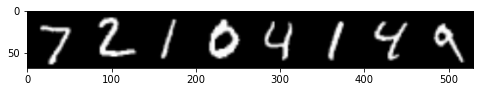

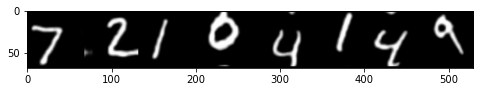

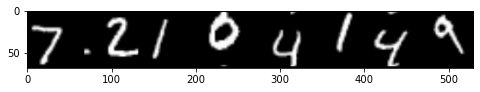

In [48]:
img, target, _dir = iter(test_dataloader).next()

model.train(False)
img = img.to(params['DEVICE'])
target = target.to(params['DEVICE'])
_dir = _dir.to(params['DEVICE'])
with torch.no_grad():
    prediction = model((img,_dir))
loss = round(F.mse_loss(prediction, target).item(),4)
print('MSE:', loss)
#print(img.size(),target.size(), prediction.size())

img = img.detach().cpu()[:8]
target = target.detach().cpu()[:8]
prediction = prediction.detach().cpu()[:8]

plot_samples_on_epoch((img+1)/2)
plot_samples_on_epoch((prediction+1)/2)
plot_samples_on_epoch((target+1)/2)

In [104]:
ddir = {1: 'down [W]',
        2: 'down+left [W+D]',
        3: 'left [D]',
        4: 'up+left [S+D]',
        5: 'up [S]',
        6: 'up+right [S+A]',
        7: 'right [A]',
        8: 'down+right [W+A]'}

down [W]


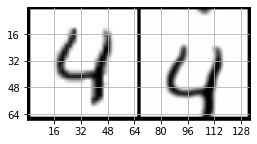

down+left [W+D]


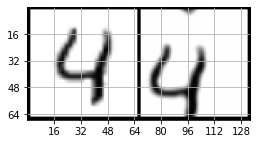

left [D]


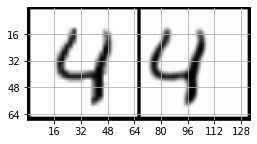

up+left [S+D]


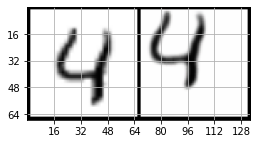

up [S]


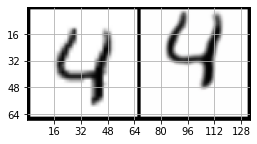

up+right [S+A]


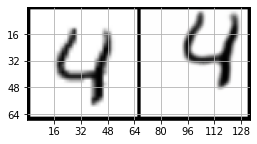

right [A]


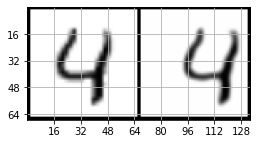

down+right [W+A]


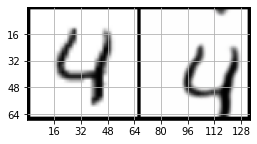

In [105]:
idx = 4

test_aug = A.Compose([A.augmentations.geometric.resize.Resize(64,64),
                      A.Normalize(mean=(0.5,), std=(0.5,)),
                      ToTensorV2(transpose_mask=False),
                      ])

img = test_set.data[idx].numpy()
img = test_aug(image=img)['image']
_,w,h = img.size()
img = img.expand_as(torch.zeros(3,w,h)) #torch.Size([3, 64, 64])
img = img.unsqueeze(0).to(params['DEVICE'])

model.train(False)
for i in range(8):
    _dir = F.one_hot(torch.tensor(i), num_classes=8).float() #torch.Size([8])
    _dir = _dir.unsqueeze(0).to(params['DEVICE'])
    with torch.no_grad():
        prediction = model((img,_dir))
        
    print(ddir[i+1])
    prediction = torch.cat([img.detach().cpu()*(-1),prediction.detach().cpu()*(-1)])
    plot_samples_on_epoch((prediction+1)/2,size=(4,4))

down [W]


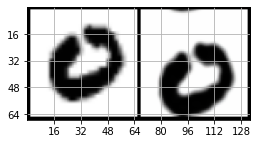

down+left [W+D]


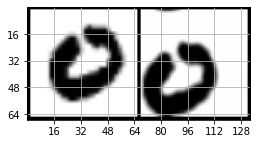

left [D]


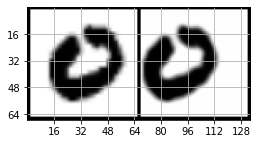

up+left [S+D]


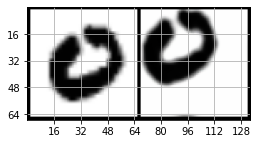

up [S]


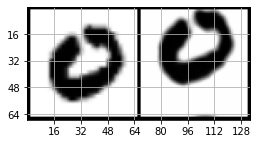

up+right [S+A]


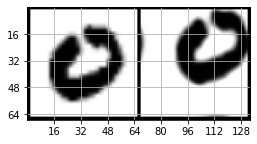

right [A]


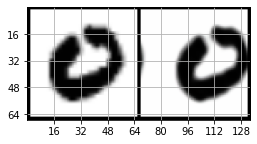

down+right [W+A]


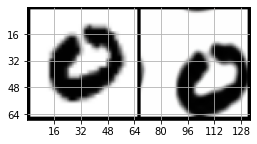

In [106]:
idx = 25

test_aug = A.Compose([A.augmentations.geometric.resize.Resize(64,64),
                      A.Normalize(mean=(0.5,), std=(0.5,)),
                      ToTensorV2(transpose_mask=False),
                      ])

img = test_set.data[idx].numpy()
img = test_aug(image=img)['image']
_,w,h = img.size()
img = img.expand_as(torch.zeros(3,w,h)) #torch.Size([3, 64, 64])
img = img.unsqueeze(0).to(params['DEVICE'])

model.train(False)
for i in range(8):
    _dir = F.one_hot(torch.tensor(i), num_classes=8).float() #torch.Size([8])
    _dir = _dir.unsqueeze(0).to(params['DEVICE'])
    with torch.no_grad():
        prediction = model((img,_dir))
        
    print(ddir[i+1])
    prediction = torch.cat([img.detach().cpu()*(-1),prediction.detach().cpu()*(-1)])
    plot_samples_on_epoch((prediction+1)/2,size=(4,4))

## Additional

torch.Size([28, 28])


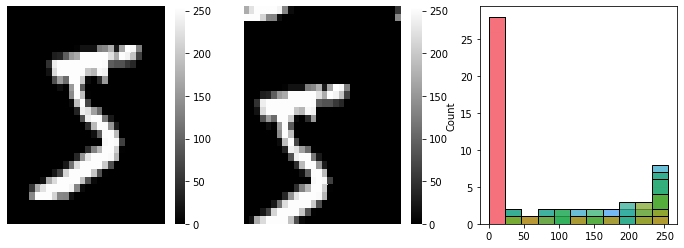

In [3]:
#torch.roll(data_batch, (0,0,-5,0), (0,1,2,3)) # if data_batch.shape=(batch,1,28,28)
sample  = train_set.data[0]
sample_target = torch.roll(sample, (5,-5), (0,1))

print(sample.shape)

fig, ax = plt.subplots(1, 3, figsize=(12,4))
sns.heatmap(data=sample,cmap='gray', xticklabels=False, yticklabels=False, ax=ax[0])
sns.heatmap(data=sample_target,cmap='gray', xticklabels=False, yticklabels=False, ax=ax[1])
sns.histplot(sample.numpy(), legend=False, ax=ax[2]);

torch.Size([32, 3, 64, 64]) torch.Size([32, 3, 64, 64]) torch.Size([32, 8])


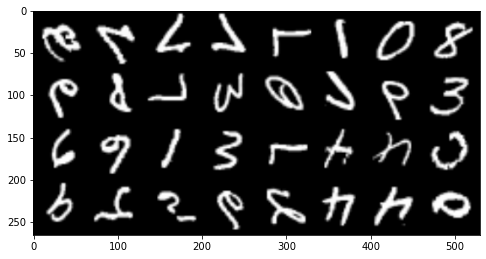

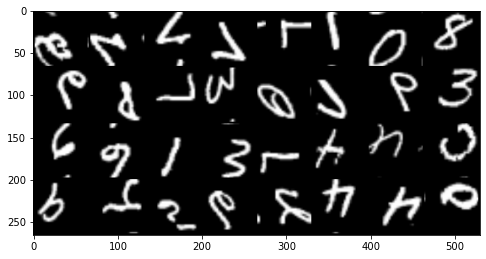

In [38]:
img, target, _dir = iter(train_dataloader).next()
print(img.size(),target.size(), _dir.size())

#print(_dir)
plot_samples_on_epoch((img+1)/2)
plot_samples_on_epoch((target+1)/2)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ResNetUNet(n_class=3).to(device)
#summary(model, (3, 64, 64), batch_size=-1)

out = model((torch.zeros(8,3,64,64).to(device),torch.zeros(8,8).to(device)))
print(out.size()) # torch.Size([8, 3, 64, 64])
print(out.min(), out.max()) 
#tensor(-0.9948, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9909, device='cuda:0', grad_fn=<MaxBackward1>)